In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ts_modelling.data_producer import DataProducer
from ts_modelling.simple_experiment import SimpleExp
from argparse import Namespace
import yaml
import torch
%matplotlib inline

with open('args.yaml', 'r') as file:
    config = yaml.safe_load(file)
args = Namespace(**config)
exp = SimpleExp(args)

length = 5000

Use CPU
self_supervised head


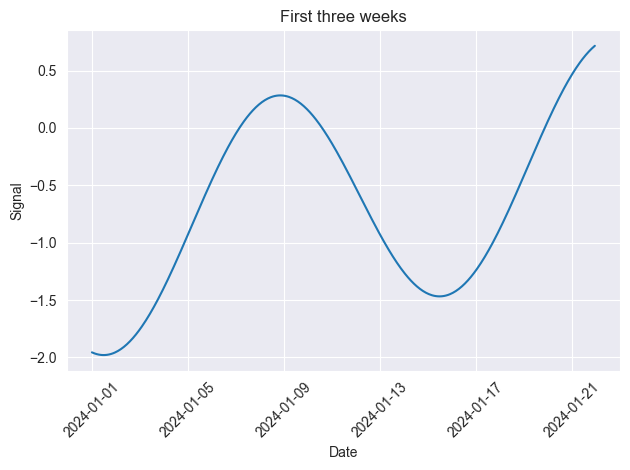

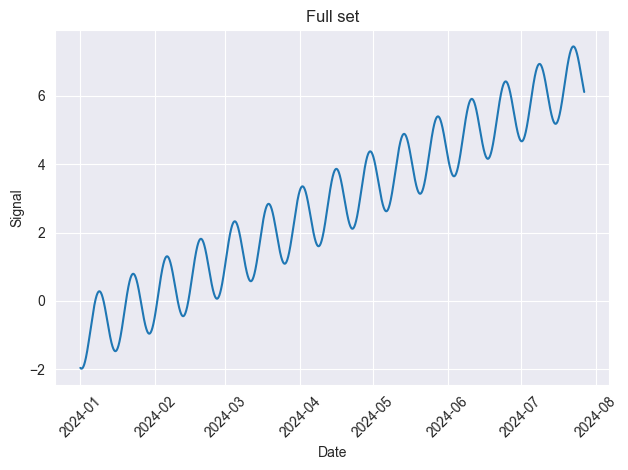

In [2]:
dp = DataProducer(length=length, n_vars=1, path=args.root_path, noise_amp=0)
dp.add_sine([(1/336, 1)])
dp.add_trend(1, 1/336)
dp.plot_data()
dp.generate_csv()

In [3]:
def forward_hook(module, input, output):
    print("Module:", module.__class__.__name__)
    print("Input:", input[0].shape)
    print("Output:", output.shape)
    print(10*'-')

In [17]:
type(exp.model.model.head)

PatchTST.PatchTST_supervised.layers.PatchTST_backbone.Flatten_Head

In [2]:
exp.model

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=128, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=128, out_features=128, bias=True)
              (W_K): Linear(in_features=128, out_features=128, bias=True)
              (W_V): Linear(in_features=128, out_features=128, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.3, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.3, inplace=False)
  

In [2]:
exp.pretrain_model()

Trainable parameters:	106508
Total parameters:		106509
train 2973
val 309
test 809
Validation loss decreased (inf --> 0.423703).  Saving model ...
Updating learning rate to 2.815846884401866e-05
Validation loss decreased (0.423703 --> 0.037414).  Saving model ...
Updating learning rate to 7.631589133909879e-05
Validation loss decreased (0.037414 --> 0.002604).  Saving model ...
Updating learning rate to 9.99999600115311e-05
Validation loss decreased (0.002604 --> 0.000858).  Saving model ...
Updating learning rate to 9.965453823531276e-05
epoch: 5, train loss: 0.017131, validation loss: 0.00029888, test loss: 0.00055991
epoch time: 2.2955338954925537
Validation loss decreased (0.000858 --> 0.000299).  Saving model ...
Updating learning rate to 9.863762671567892e-05
EarlyStopping counter: 1 out of 15
Updating learning rate to 9.69629774364373e-05
EarlyStopping counter: 2 out of 15
Updating learning rate to 9.46532371562558e-05
Validation loss decreased (0.000299 --> 0.000282).  Saving m

In [3]:
exp.train_predict_head()

Trainable parameters:	712896
Total parameters:		817857
train 2973
val 309
test 809
Validation loss decreased (inf --> 0.074990).  Saving model ...
Updating learning rate to 2.815846884401866e-05
Validation loss decreased (0.074990 --> 0.031320).  Saving model ...
Updating learning rate to 7.631589133909879e-05
Validation loss decreased (0.031320 --> 0.011277).  Saving model ...
Updating learning rate to 9.99999600115311e-05
Validation loss decreased (0.011277 --> 0.005418).  Saving model ...
Updating learning rate to 9.965453823531276e-05
epoch: 5, train loss: 0.021629, validation loss: 0.0034416, test loss: 0.0033994
epoch time: 1.661181926727295
Validation loss decreased (0.005418 --> 0.003442).  Saving model ...
Updating learning rate to 9.863762671567892e-05
Validation loss decreased (0.003442 --> 0.002436).  Saving model ...
Updating learning rate to 9.69629774364373e-05
Validation loss decreased (0.002436 --> 0.001820).  Saving model ...
Updating learning rate to 9.46532371562558

In [ ]:
exp.finetune_model()

Trainable parameters:	817857
Total parameters:		817857
train 2973
val 309
test 809
Validation loss decreased (inf --> 0.000549).  Saving model ...
Updating learning rate to 2.815846884401866e-05
EarlyStopping counter: 1 out of 15
Updating learning rate to 7.631589133909879e-05
EarlyStopping counter: 2 out of 15
Updating learning rate to 9.99999600115311e-05
EarlyStopping counter: 3 out of 15
Updating learning rate to 9.965453823531276e-05
epoch: 5, train loss: 0.0093847, validation loss: 0.00070501, test loss: 0.00067752
epoch time: 2.8647830486297607
EarlyStopping counter: 4 out of 15
Updating learning rate to 9.863762671567892e-05


In [3]:
exp.swap_head('supervised')
for param in exp.model.model.backbone.parameters():
    param.requires_grad = False

In [4]:
exp.model

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=128, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=128, out_features=128, bias=True)
              (W_K): Linear(in_features=128, out_features=128, bias=True)
              (W_V): Linear(in_features=128, out_features=128, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.3, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.3, inplace=False)
  

In [4]:
exp.args.training_task = 'supervised'
exp.train()

Trainable parameters:	712896
Total parameters:		817857
train 2973
val 309
test 809
Validation loss decreased (inf --> 0.017844).  Saving model ...
Updating learning rate to 9.999964010416366e-05
Validation loss decreased (0.017844 --> 0.001809).  Saving model ...
Updating learning rate to 9.69194207852955e-05
Validation loss decreased (0.001809 --> 0.000900).  Saving model ...
Updating learning rate to 8.818005098577033e-05
Validation loss decreased (0.000900 --> 0.000711).  Saving model ...
Updating learning rate to 7.483562768277244e-05
epoch: 5, train loss: 0.015703, validation loss: 0.00052858, test loss: 0.00049945
epoch time: 1.6927330493927002
Validation loss decreased (0.000711 --> 0.000529).  Saving model ...
Updating learning rate to 5.849568526935634e-05
Validation loss decreased (0.000529 --> 0.000437).  Saving model ...
Updating learning rate to 4.113106195244662e-05
Validation loss decreased (0.000437 --> 0.000281).  Saving model ...
Updating learning rate to 2.4836187578

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=128, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=128, out_features=128, bias=True)
              (W_K): Linear(in_features=128, out_features=128, bias=True)
              (W_V): Linear(in_features=128, out_features=128, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.3, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.3, inplace=False)
  

In [5]:
for param in exp.model.model.backbone.parameters():
    param.requires_grad = True

exp.train()

Trainable parameters:	817857
Total parameters:		817857
train 2973
val 309
test 809
Validation loss decreased (inf --> 0.001132).  Saving model ...
Updating learning rate to 9.999964010416366e-05
Validation loss decreased (0.001132 --> 0.000965).  Saving model ...
Updating learning rate to 9.69194207852955e-05
Validation loss decreased (0.000965 --> 0.000880).  Saving model ...
Updating learning rate to 8.818005098577033e-05
Validation loss decreased (0.000880 --> 0.000568).  Saving model ...
Updating learning rate to 7.483562768277244e-05
epoch: 5, train loss: 0.0081161, validation loss: 0.00041399, test loss: 0.00039396
epoch time: 3.291706085205078
Validation loss decreased (0.000568 --> 0.000414).  Saving model ...
Updating learning rate to 5.849568526935634e-05
Validation loss decreased (0.000414 --> 0.000299).  Saving model ...
Updating learning rate to 4.113106195244662e-05
Validation loss decreased (0.000299 --> 0.000185).  Saving model ...
Updating learning rate to 2.4836187578

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=128, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=128, out_features=128, bias=True)
              (W_K): Linear(in_features=128, out_features=128, bias=True)
              (W_V): Linear(in_features=128, out_features=128, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.3, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.3, inplace=False)
  

## todo:
- make model be able data of same input (permute/view or something)
- hide some patches (after patching in backbone forward)
- validate in same manner
  - a first approach is to use the mse loss as usual, however this will be a bit blunt since we will get a lot of patches that are fed to the model
  - a better way would be to only calculate the loss of missing patches, however this requires some more work


In [8]:
sum(p. for p in exp.model.model.backbone.parameters())

104961

In [15]:
total_params = 0
print('Name: \t Params:')
for name, parameter in exp.model.model.head.named_parameters():
    if not parameter.requires_grad:
        continue
    params = parameter.numel()
    print(f'{name}\t {params}')
    total_params += params
print(f"Total Trainable Params: {total_params}")

Name: 	 Params:
linear.weight	 712704
linear.bias	 192
Total Trainable Params: 712896
